# Exercise
- file name: discrete_anomaly_detection.py or discrete_anomaly_detection.ipynb
- Save this work in your anomaly-detection-exercises repo. Then add, commit, and push your changes.


# 1) Discrete Data + Probability
- Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.


In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df_orig.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df_orig.shape

(13974, 7)

In [5]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [6]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [7]:
df.shape

(13978, 7)

In [8]:
df.request_method.value_counts()

"GET /api/v1/sales?page=2 HTTP/1.1"                       709
"GET /api/v1/items HTTP/1.1"                              464
"GET /api/v1/items?page=2 HTTP/1.1"                       291
"GET /api/v1/items?page=3 HTTP/1.1"                       219
"GET /api/v1/stores HTTP/1.1"                             162
                                                         ... 
GET /api/v1/items/HTTP/1.1                                  1
"GET /api/v1//api/v1/items HTTP/1.1"                        1
"GET /api/v1/stores?page=666 HTTP/1.1"                      1
"GET /api/v1/items/api/v1/items?page=3 HTTP/1.1"            1
"GET /api/v1/items?page=99999999999999999998 HTTP/1.1"      1
Name: request_method, Length: 220, dtype: int64

In [9]:
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [10]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [11]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [12]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [13]:
ip_df = pd.DataFrame(df.size_mb.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'size_mb', 'size_mb': 'size_mb_count'})
ip_df2 = pd.DataFrame(df.size_mb.value_counts(dropna=False)/df.size_mb.count()).reset_index().\
                rename(index=str, columns={'index': 'size_mb', 'size_mb': 'size_mb_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.size_mb_proba < .01]

,size_mb,size_mb_count,size_mb_proba
8,0.486506,129,0.009229
9,0.486511,126,0.009014
10,0.487878,125,0.008943
11,0.486506,123,0.008800
12,0.486488,123,0.008800
...,...,...,...
186,0.000958,1,0.000072
187,0.312356,1,0.000072
188,1.961066,1,0.000072
189,0.343606,1,0.000072


191
      size_mb  size_mb_count  size_mb_proba
181  1.099591              1       0.000072
182  0.327981              1       0.000072
183  0.002441              1       0.000072
184  0.390481              1       0.000072
185  0.000120              1       0.000072
186  0.000958              1       0.000072
187  0.312356              1       0.000072
188  1.961066              1       0.000072
189  0.343606              1       0.000072
190  0.265481              1       0.000072


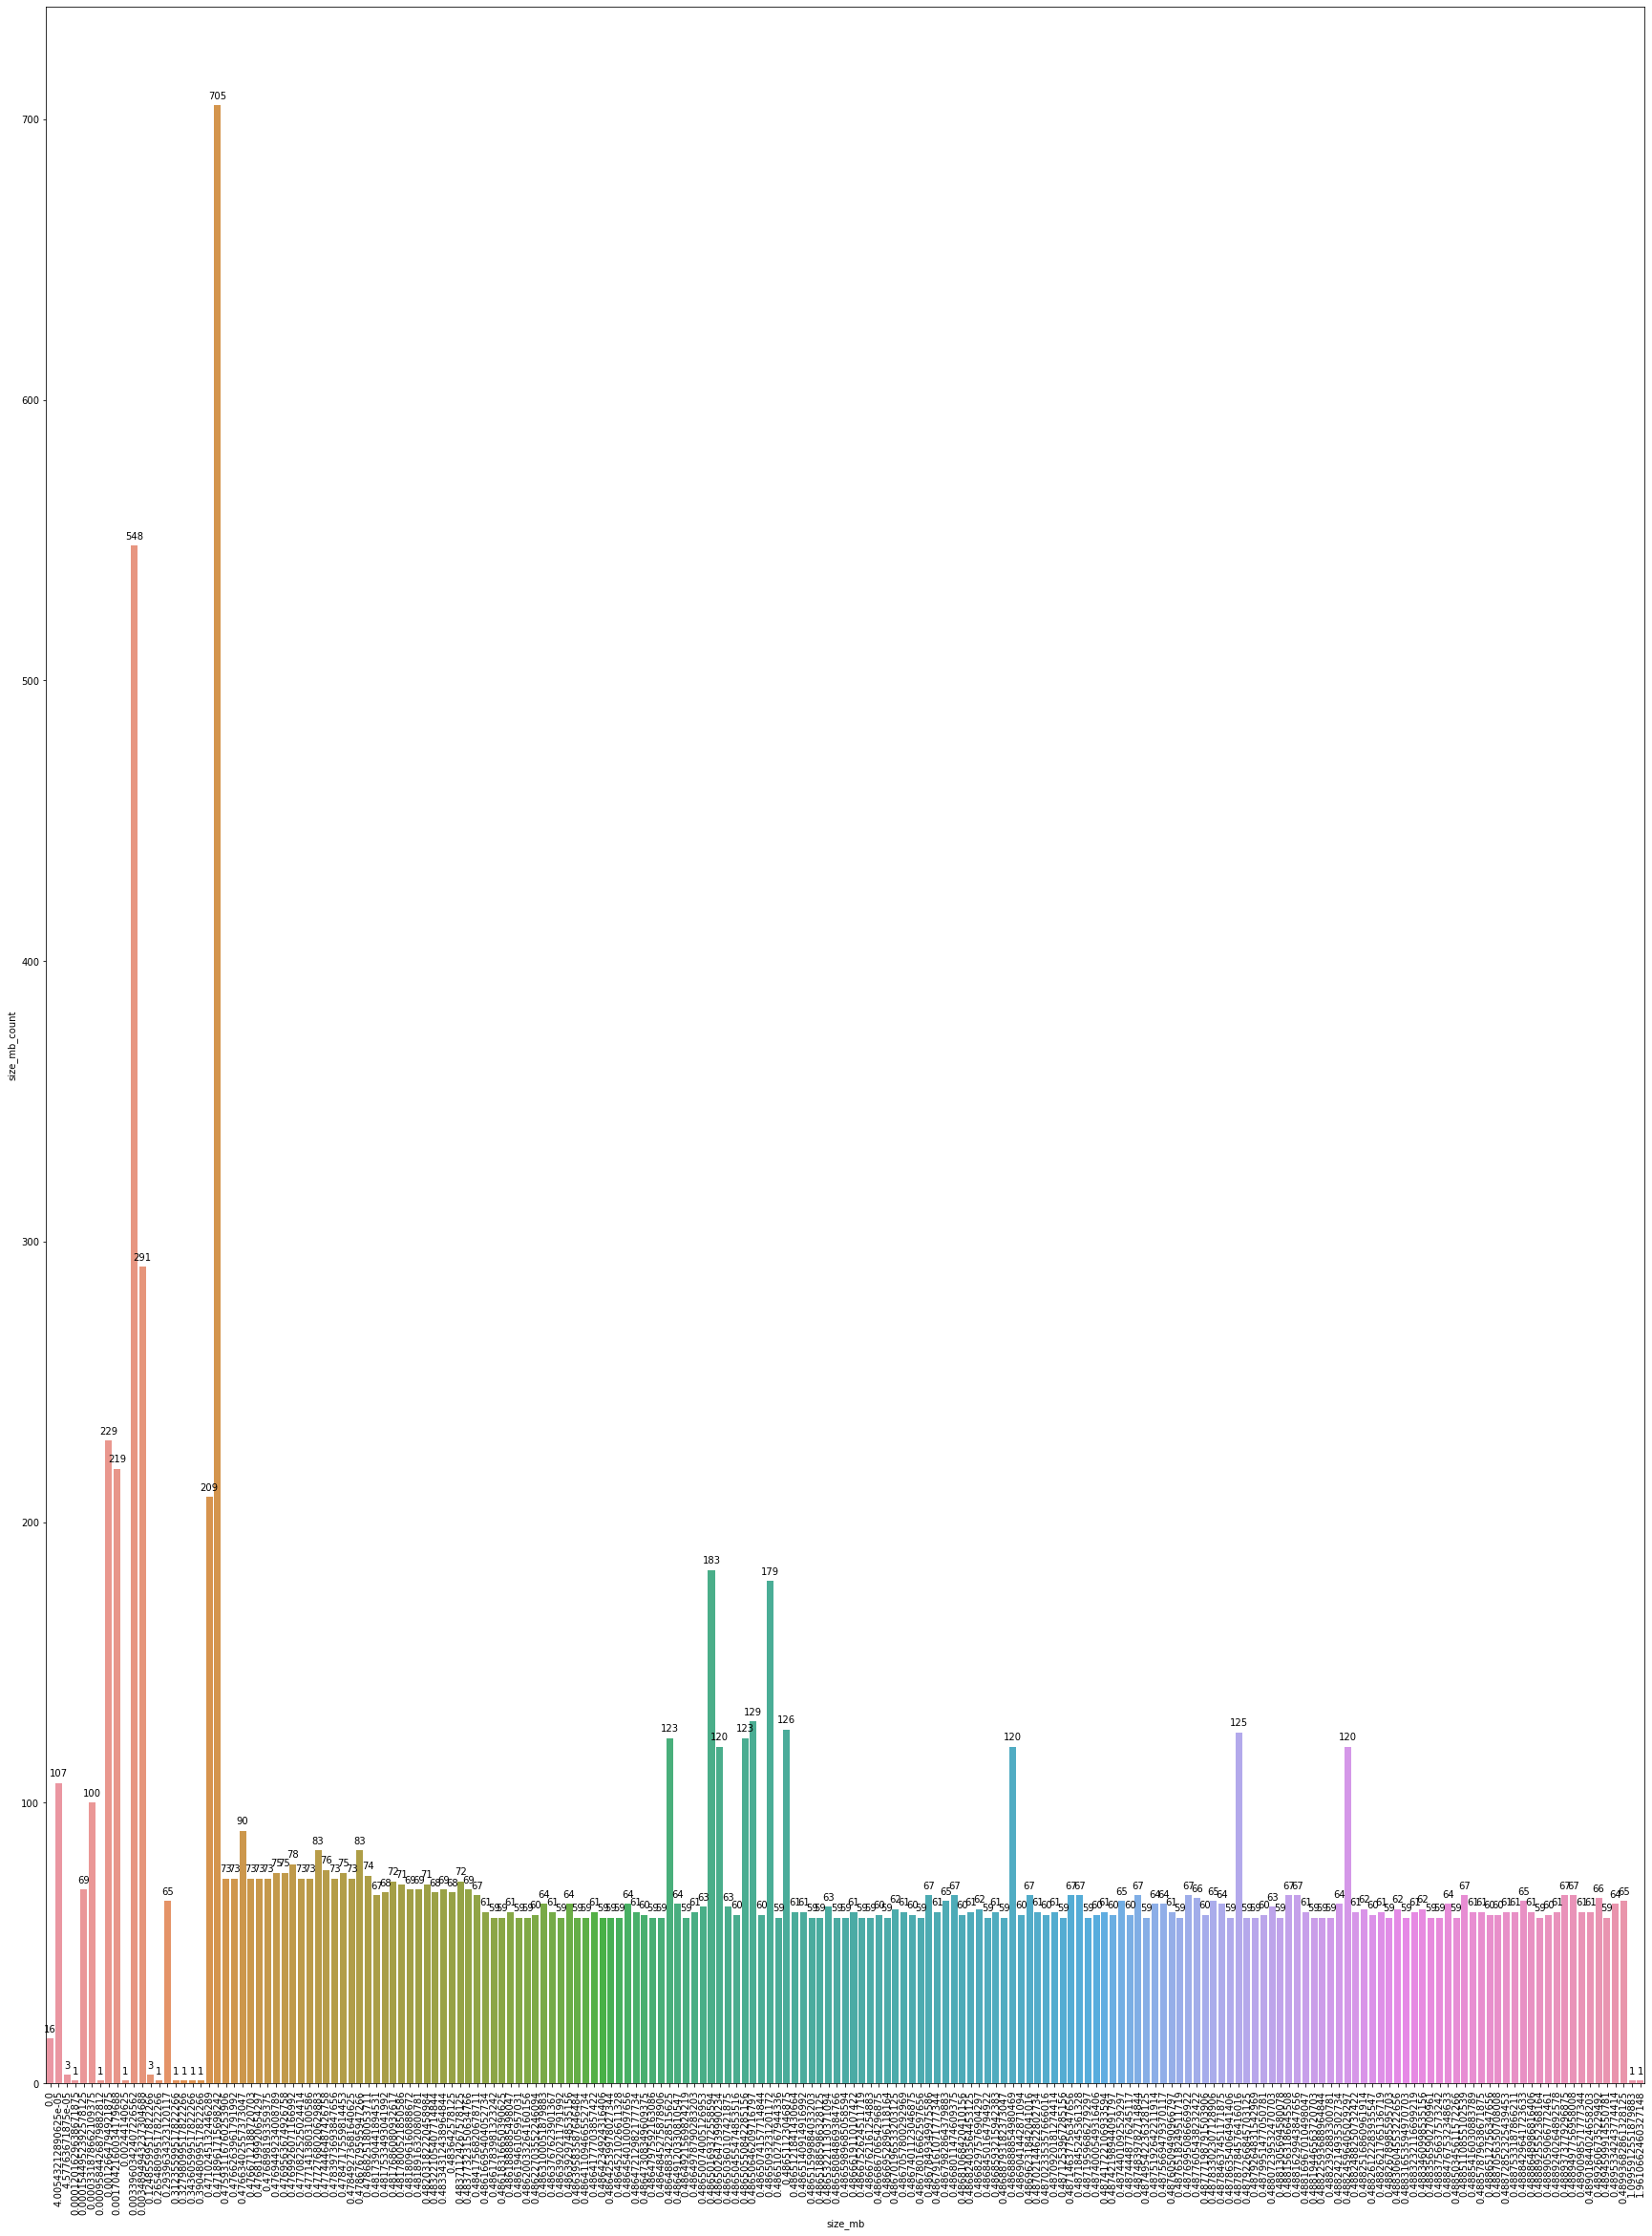

In [14]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(30, 40))
splot = sns.barplot(data=ip_df, x = 'size_mb', y = 'size_mb_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [15]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [16]:
train.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [17]:
size_mb_df = pd.DataFrame(train.size_mb.value_counts(dropna=False)/train.size_mb.count()).reset_index().\
        rename(index=str, columns={'index': 'size_mb', 'size_mb': 'size_mb_proba'})

In [18]:
size_mb_df.head()

,size_mb,size_mb_proba
0,0.471896,0.050451
1,0.003396,0.039216
2,0.003489,0.020824
3,0.001266,0.016388
4,0.001704,0.015672


In [21]:
ip_df

,size_mb,size_mb_count,size_mb_proba
0,0.471896,705,0.050436
1,0.003396,548,0.039204
2,0.003489,291,0.020818
3,0.001266,229,0.016383
4,0.001704,219,0.015667
...,...,...,...
186,0.000958,1,0.000072
187,0.312356,1,0.000072
188,1.961066,1,0.000072
189,0.343606,1,0.000072


In [23]:
df = df.reset_index().merge(ip_df, on=['size_mb'], how='left').fillna(value=0).set_index('timestamp')
df.size_mb_proba.value_counts()

0.004221    2478
0.004364    1769
0.004292    1080
0.004793     938
0.050436     705
0.005222     657
0.004579     640
0.039204     548
0.004650     390
0.008585     360
0.004936     345
0.004436     310
0.020818     291
0.004507     252
0.008800     246
0.016383     229
0.005366     225
0.015667     219
0.014952     209
0.004865     204
0.013092     183
0.012806     179
0.005938     166
0.005151     144
0.005079     142
0.004722     132
0.009229     129
0.009014     126
0.008943     125
0.007655     107
0.007154     100
0.006439      90
0.005580      78
0.005437      76
0.005294      74
0.001145      16
0.000072      10
0.000215       6
Name: size_mb_proba, dtype: int64

In [24]:
ip_probs = train.groupby('size_mb').size().div(len(df))

status_given_size_mb = pd.DataFrame(train.groupby(['size_mb', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='size_mb').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_size_mb'})
                              )

In [28]:
size_mb_status_count = pd.DataFrame(train.groupby(['size_mb', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'size_mb_status_count'}))


size_mb_status = status_given_size_mb.merge(size_mb_status_count)

In [29]:
df = df.reset_index().merge(size_mb_status, on=['size_mb', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [30]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,size_mb_count,size_mb_proba,proba_status_given_size_mb,size_mb_status_count
timestamp,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,61,0.004364,1.000286,61.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,548,0.039204,1.000286,548.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,61,0.004364,1.000286,61.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,61,0.004364,1.000286,61.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,120,0.008585,1.000286,120.0


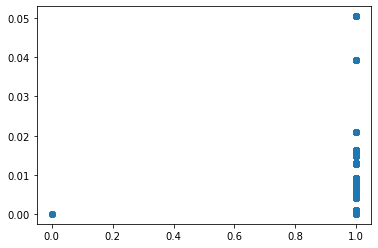

In [32]:
plt.scatter(df.proba_status_given_size_mb, df.size_mb_proba)